In [1]:
import sys
import os
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series


training_dir = os.path.join(os.path.dirname("training/"), '')
sys.path.append(training_dir)
print(training_dir)

training/


   DOW      Date  Atlanta IN  Atlanta OUT  Atlanta NET  Atlanta INV  \
0  Sun  1/1/2017        4630            0         4630         4630   
1  Mon  1/2/2017        6609            0         6609        11239   
2  Tue  1/3/2017         987            0          987        12226   
3  Wed  1/4/2017        2537            0         2537        14763   
4  Thu  1/5/2017       19207            0        19207        33970   

   Chicago IN  Chicago OUT  Chicago NET  Chicago INV  ...  Nashville NET  \
0        1695            0         1695         1695  ...           7656   
1        5059            0         5059         6754  ...           7404   
2       10384            0        10384        17138  ...           4158   
3        8127            0         8127        25265  ...           2769   
4        4016            0         4016        29281  ...           7890   

   Nashville INV  LA IN  LA OUT  LA NET  LA INV  NY IN  NY OUT  NY NET  NY INV  
0           7656  10469       0   1

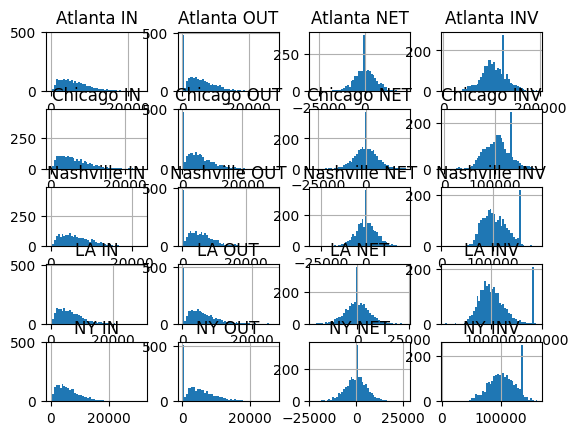

In [2]:
import matplotlib.pyplot as plt
data = pd.read_csv("src/csv/RUNNING TOTALS H25.csv")
print(data.head())
data.set_index('Date', inplace=True)
data.hist(bins=50)
plt.show()


In [3]:
import asyncio
import requests
import src.analysis.data_parser as data_parser
import src.netsuite_connection.connection as netsuite_connection



In [13]:
# Rerun the 2024 regression-style forecast using the corrected sheet.
import pandas as pd
import numpy as np
from datetime import timedelta

# ---------- Load & reshape ----------
path = "src/csv/RUNNING TOTALS H25.csv"
raw = pd.read_csv(path)

# Use first data row as header (matches prior structure)
df = raw.iloc[1:].copy()
df.columns = list(raw.iloc[0])

#Add headers back to df
columns = raw.columns.tolist()
df.columns = columns

# Parse and clean dates
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()



[[<Axes: title={'center': 'Date'}> <Axes: title={'center': 'IN'}>]
 [<Axes: title={'center': 'INV'}> <Axes: title={'center': 'NET'}>]
 [<Axes: title={'center': 'OUT'}> <Axes: >]]


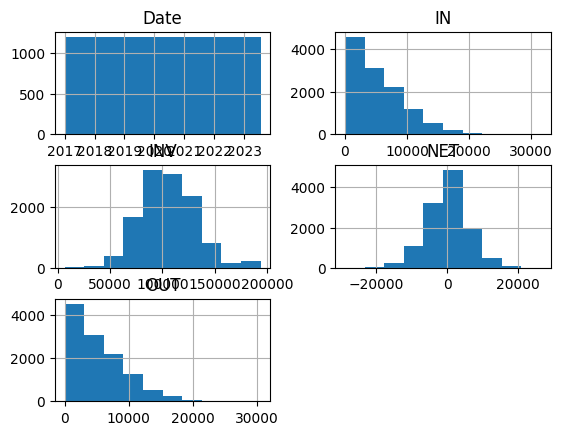

In [39]:
# Identify warehouse metric columns and melt
value_cols = [c for c in df.columns if c not in ["DOW", "Date"]]
rows = []
for c in value_cols:
    parts = str(c).rsplit(" ", 1)
    if len(parts) == 2:
        wh, metric = parts[0], parts[1].upper()
    else:
        continue
    vals = pd.to_numeric(df[c], errors="coerce")
    rows.append(pd.DataFrame({"Date": df["Date"], "Warehouse": wh, "Metric": metric, "Value": vals}))

tidy = pd.concat(rows, ignore_index=True).dropna(subset=["Value"])
wide = tidy.pivot_table(index=["Date", "Warehouse"], columns="Metric", values="Value", aggfunc="first").reset_index()

print(wide.hist())



In [38]:
# Make daily continuous
def reindex_daily(g):
    print(g.head())
    g = g.set_index("Date").asfreq("D")
    # print(g.head())
    g["Warehouse"] = g["Warehouse"].ffill().bfill()
    g["IN"] = g["IN"].fillna(0.0)
    g["OUT"] = g["OUT"].fillna(0.0)
    return g.reset_index()

daily = wide.groupby("Warehouse", group_keys=False).apply(reindex_daily(wide), include_groups=False)
print(daily.head())
# daily = daily.sort_values(["Warehouse", "Date"])


Metric       Date  Warehouse    IN    INV   NET  OUT
0      2017-01-02    Atlanta  6609  11239  6609    0
1      2017-01-02    Chicago  5059   6754  5059    0
2      2017-01-02         LA  3587  14056  3587    0
3      2017-01-02         NY  2978   9430  2978    0
4      2017-01-02  Nashville  7404  15060  7404    0


ValueError: cannot reindex on an axis with duplicate labels